Testing correlated noise generation based on GALSIM methodology.

In [6]:
from EXPANSE.utils import model_and_apply_correlated_noise
from EXPANSE import MockResolvedGalaxy, ResolvedGalaxy
from matplotlib import pyplot as plt
import numpy as np
from astropy.io import fits

%matplotlib inline

In [2]:
file = '/Users/user/Downloads/jw02738-o001_t001_nircam_clear-f444w_i2dnobg.fits'

with fits.open(file) as hdul:
    data = hdul[1].data

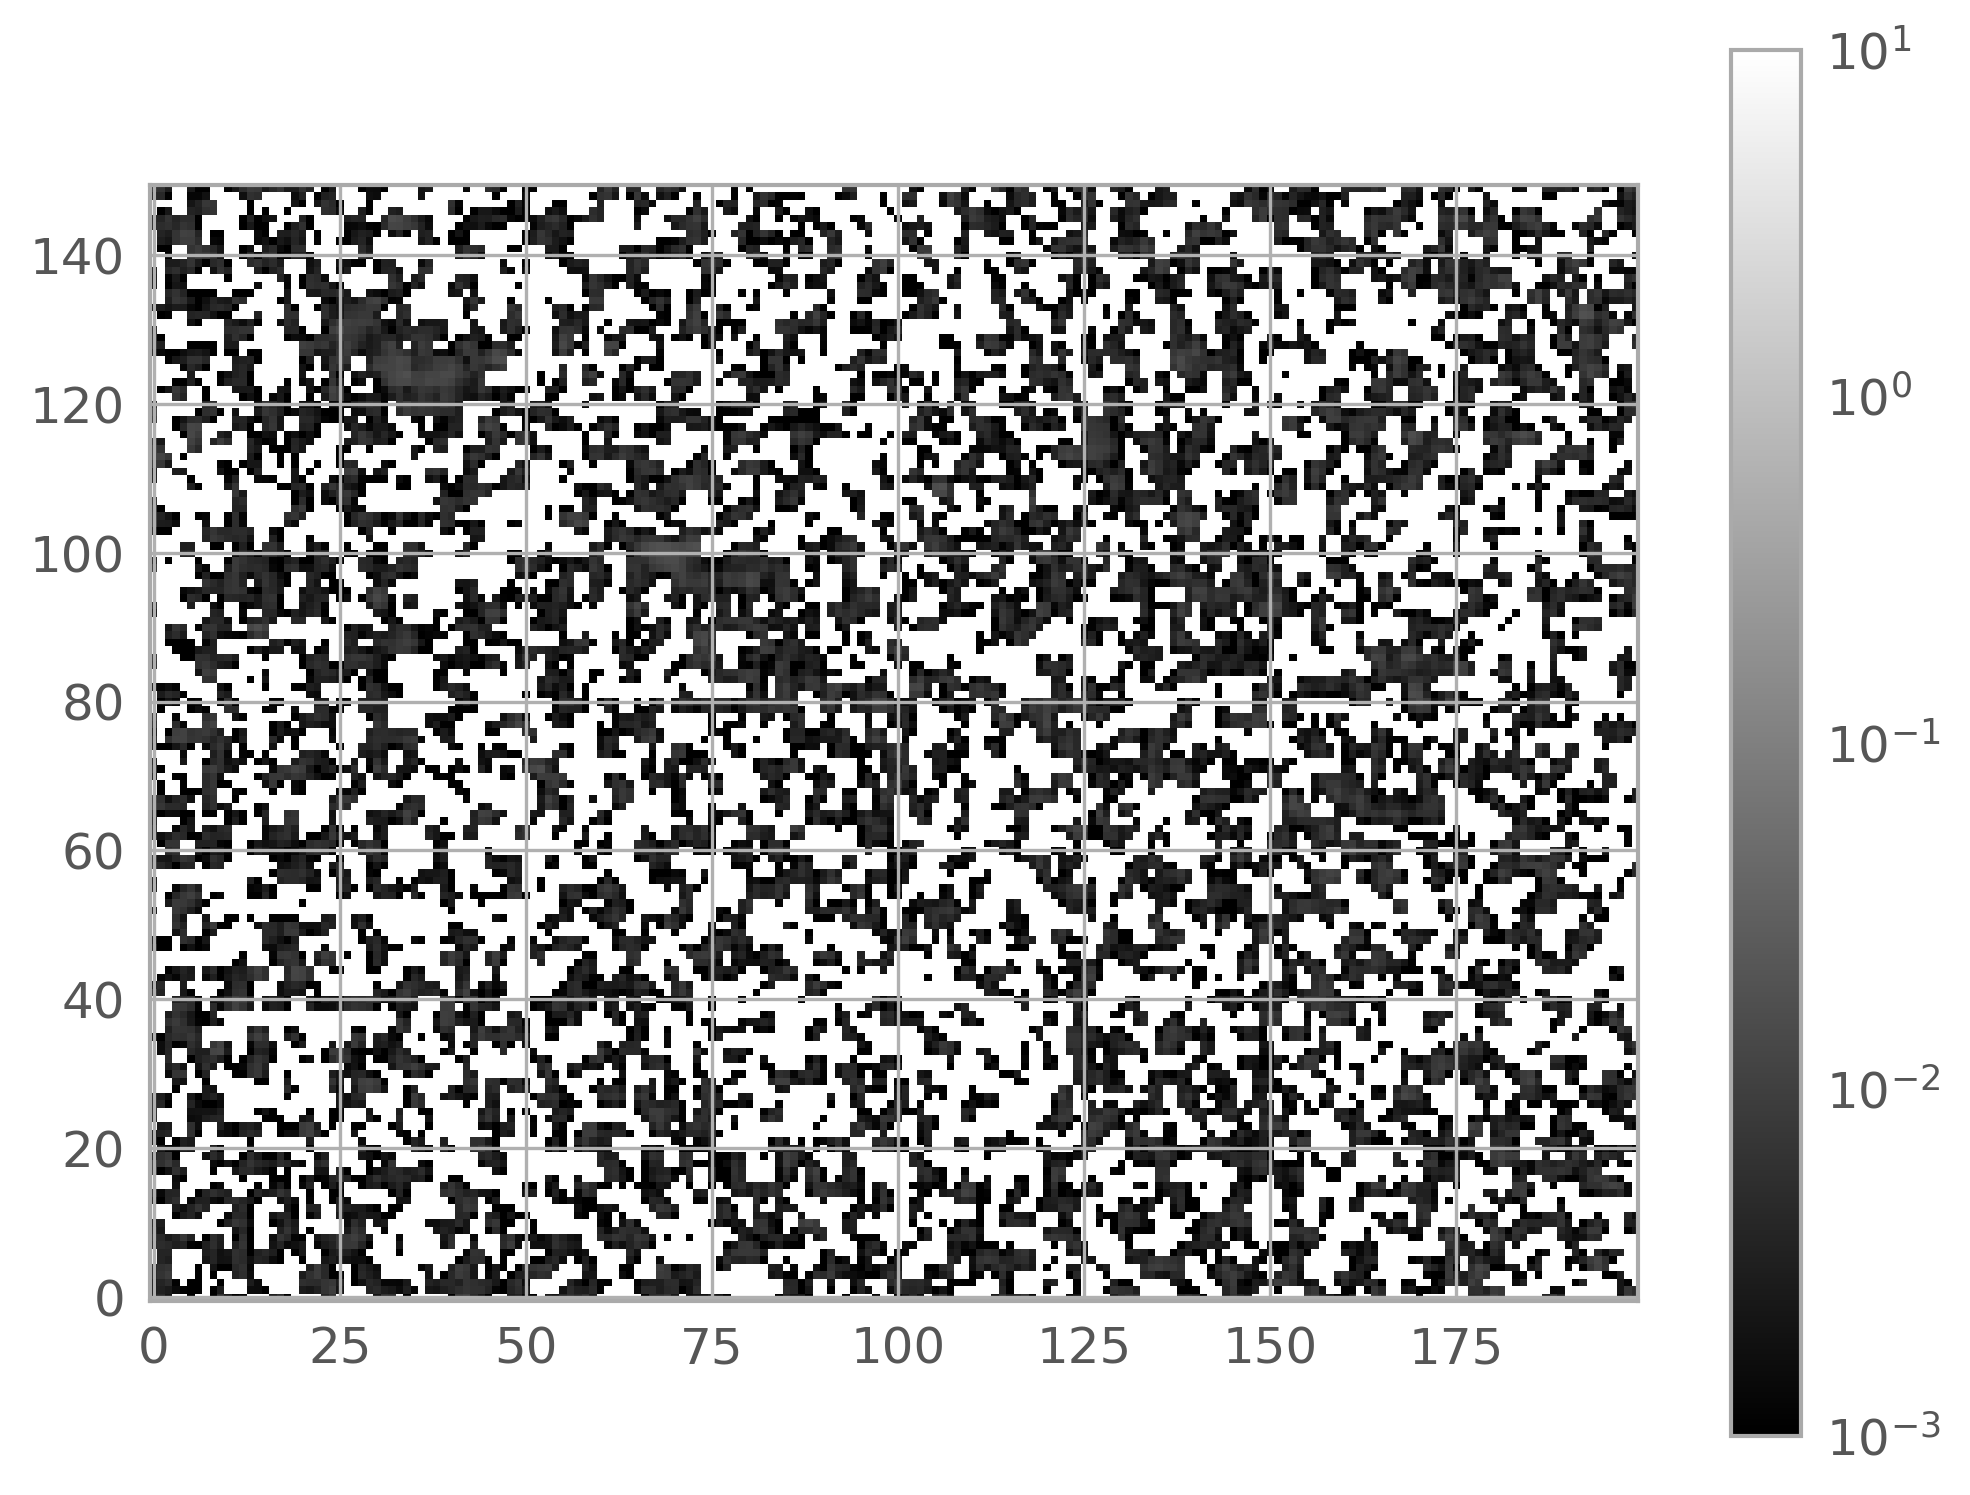

In [9]:
cropped_data = data[2300:2450, 3500:3700]

plt.imshow(cropped_data, origin='lower', cmap='gray', norm='log', vmin=1e-3, vmax=10)
plt.colorbar()


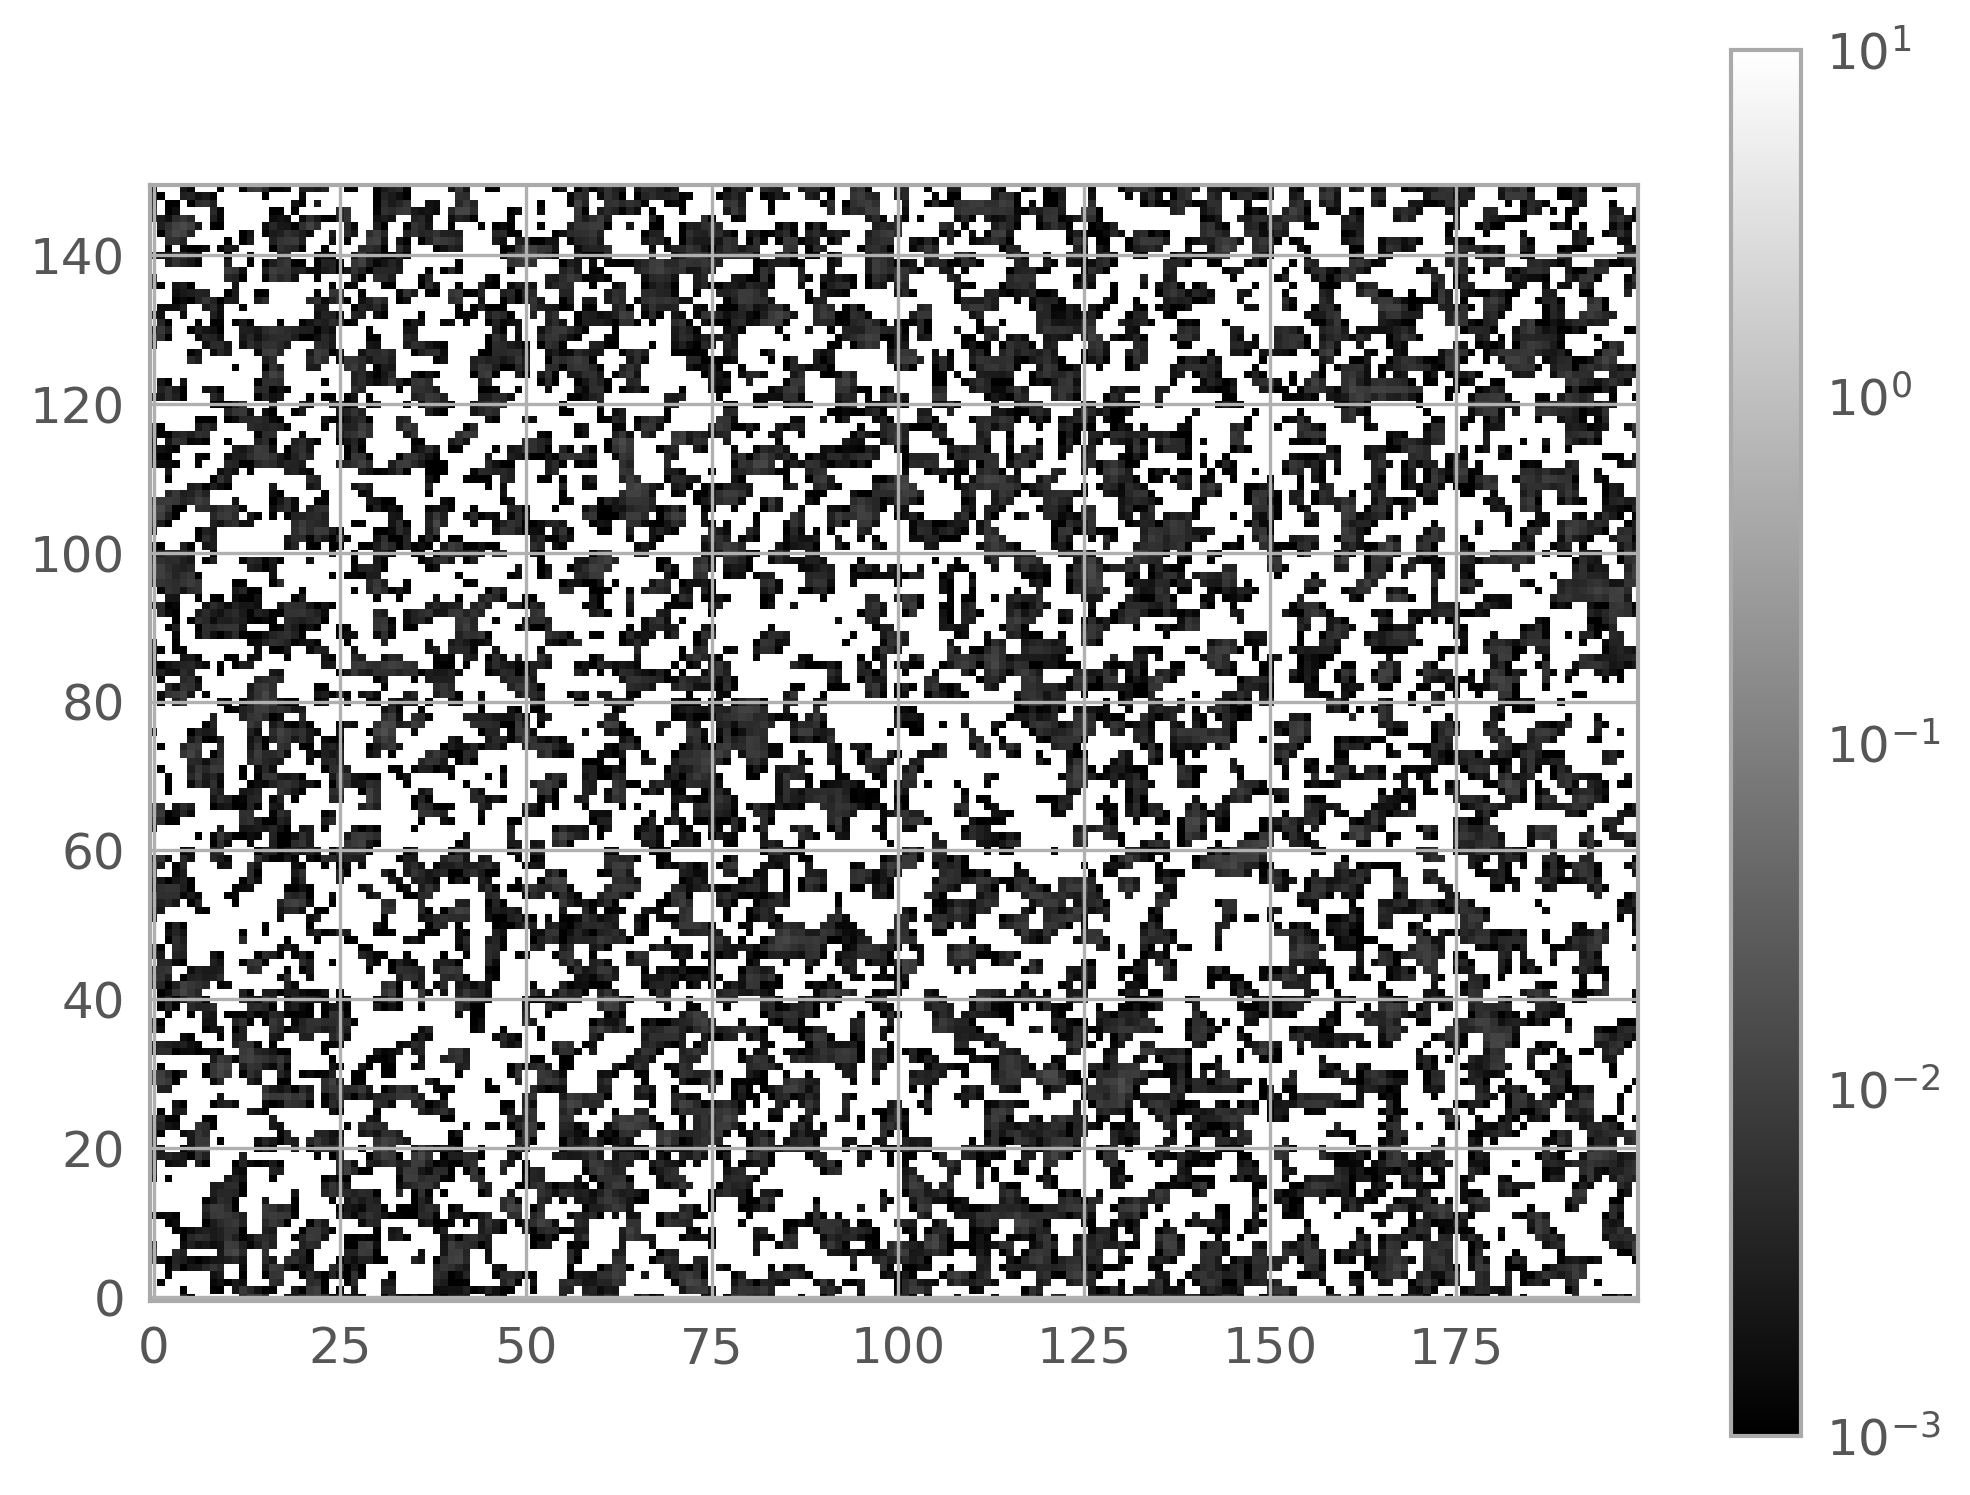

In [15]:
dummy = np.zeros_like(cropped_data)

arr = noisy_bckg = model_and_apply_correlated_noise(
    source_image_arr=cropped_data,
    target_image_arr=dummy,
    subtract_mean=True,
    correct_periodicity=False,
    rng_seed=42,
)

fig = plt.figure()
plt.imshow(arr, origin='lower', cmap='gray', norm='log', vmin=1e-3, vmax=10)
plt.colorbar()
fig;

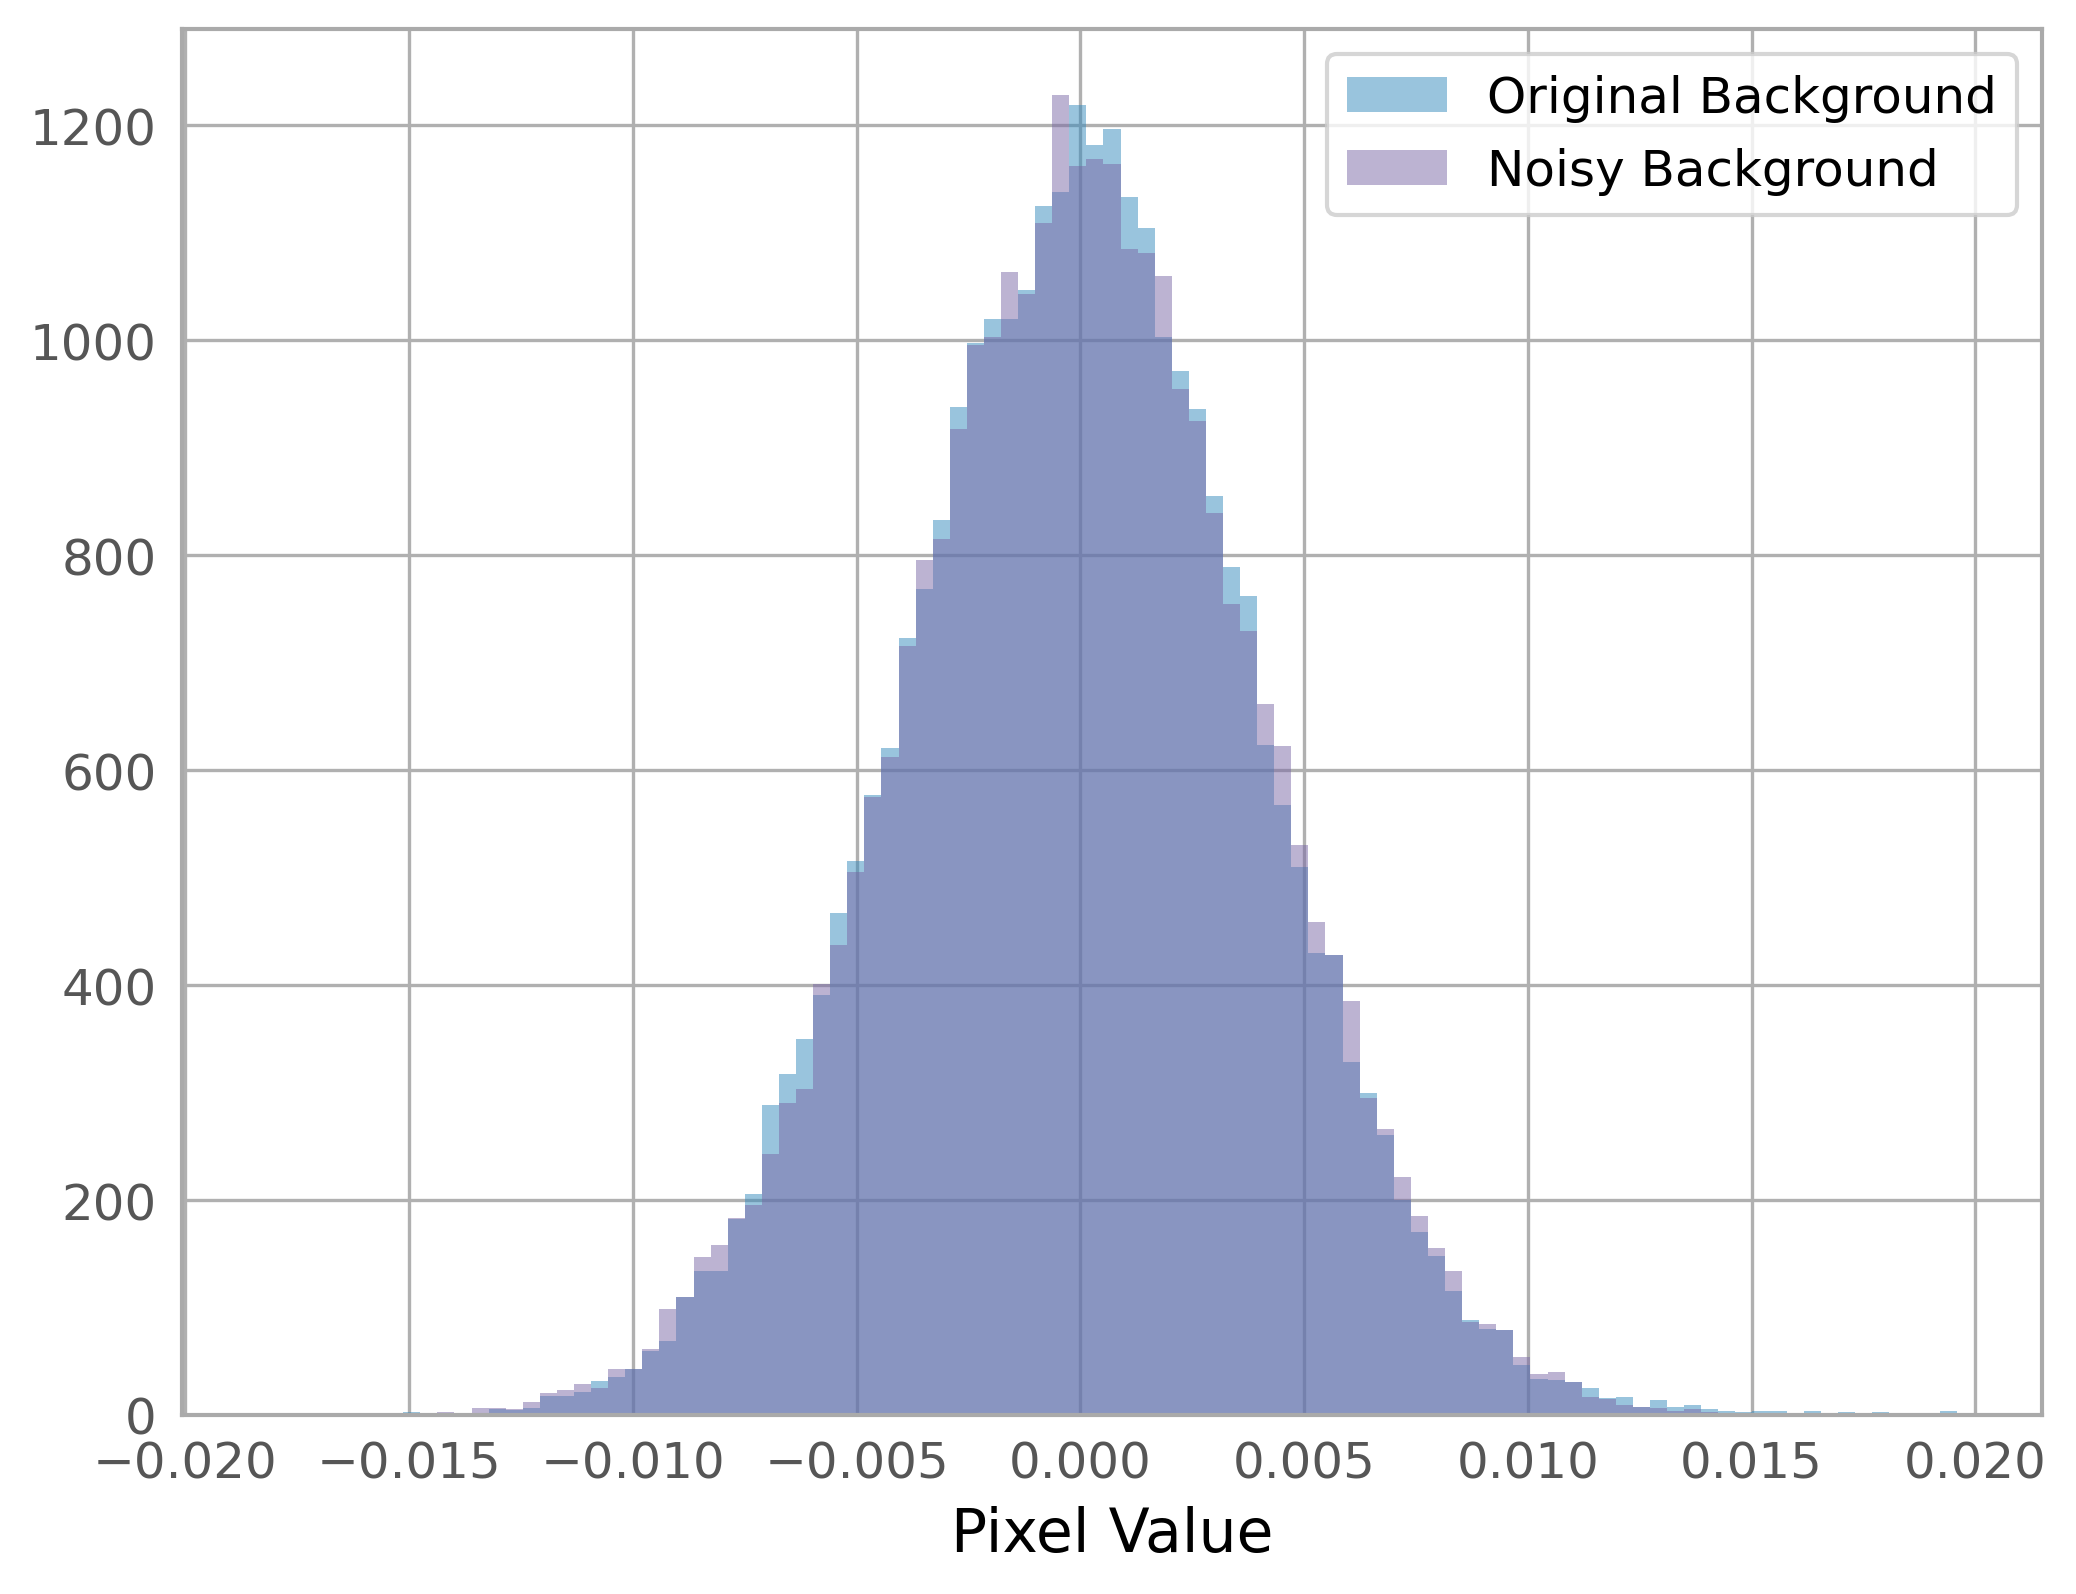

In [16]:
# Compute bins
bmin = min(cropped_data.flatten().min(), arr.flatten().min())
bmax = max(cropped_data.flatten().max(), arr.flatten().max())
bins = np.linspace(bmin, bmax, 100)

plt.hist(cropped_data.flatten(), bins=bins, alpha=0.5, label='Original Background');
plt.hist(arr.flatten(), bins=bins, alpha=0.5, label='Noisy Background');

plt.xlabel('Pixel Value')
plt.legend()
plt.grid(zorder=0.5)

In [26]:
import numpy as np
from typing import Tuple, Optional

def calculate_radial_correlation(
    image_arr: np.ndarray,
    subtract_mean: bool = True,
    max_pixel_distance: Optional[int] = None
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Calculates the radially averaged auto-correlation of pixel values in an image
    as a function of pixel distance.

    The auto-correlation is normalized by the variance of the (mean-subtracted)
    image, so the correlation at zero distance is 1.0 (assuming non-zero variance).

    Args:
        image_arr: 2D NumPy array representing the image.
        subtract_mean: If True (default), subtracts the overall mean of the image
                       before calculating the correlation. This is generally
                       recommended for interpreting the result as a standard
                       correlation coefficient.
        max_pixel_distance: The maximum integer pixel distance (radius) for which
                            to calculate the average correlation. If None, it
                            defaults to a value based on the image dimensions
                            (typically half the smallest dimension, or the full
                            extent for 1D-like images).

    Returns:
        A tuple (distances, correlations):
        - distances: 1D NumPy array of integer pixel distances [0, 1, 2, ...].
        - correlations: 1D NumPy array of the corresponding radially averaged
                        correlation coefficients. The correlation at distance 0
                        is 1.0 if the image has non-zero variance. Values for
                        distances where no pixels are found (e.g., beyond image
                        bounds for a given max_pixel_distance) will be NaN.
    """
    if image_arr.ndim != 2:
        raise ValueError("Input image must be a 2D numpy array.")

    ny, nx = image_arr.shape

    if subtract_mean:
        # Work with a float version for precision if subtracting mean
        processed_image = image_arr.astype(float) - np.mean(image_arr)
    else:
        # If not subtracting mean, ensure it's float for FFT, operate on copy
        processed_image = image_arr.astype(float, copy=True)

    # Compute 2D Auto-Correlation Function using FFTs
    # FT(I) = F (Fourier Transform of the processed image)
    # Power Spectrum PS = F * conj(F)
    # The Inverse FFT of PS gives the unnormalized auto-covariance function.
    # The element (0,0) of this IFFT(PS) is sum_pixels(processed_image**2).
    
    ft_array = np.fft.rfft2(processed_image)
    power_spectrum = np.abs(ft_array)**2  # Element-wise squared magnitude

    # Inverse FFT of the power spectrum gives the unnormalized auto-covariance
    auto_covariance_unrolled = np.fft.irfft2(power_spectrum, s=processed_image.shape)
    
    # The value at lag (0,0) of the unnormalized auto-covariance
    # is sum(processed_image**2).
    variance_numerator_term = auto_covariance_unrolled[0,0]

    # Handle images with effectively zero variance (e.g., flat images)
    # Small epsilon relative to image size to define "effectively zero"
    epsilon = 1e-12 * np.prod(processed_image.shape)
    if variance_numerator_term < epsilon:
        center_y_temp, center_x_temp = ny // 2, nx // 2
        if max_pixel_distance is None:
            # For 1D-like arrays (e.g., 1xN or Nx1), use the available extent
            if ny == 1 or nx == 1:
                 max_r = max(center_y_temp, center_x_temp)
            else: # For 2D arrays, default to half the minimum dimension
                 max_r = min(center_y_temp, center_x_temp)
        else:
            max_r = max_pixel_distance
        
        max_r = max(0, int(np.floor(max_r))) # Ensure non-negative integer

        distances = np.arange(max_r + 1)
        correlations = np.full_like(distances, np.nan, dtype=float)
        if len(correlations) > 0:
            # Correlation of a variable with itself is 1, even if variance is 0.
            correlations[0] = 1.0 
        return distances, correlations

    # Normalize by the value at (0,0) lag to get the auto-correlation coefficient function.
    # rho(lag) = Cov(lag) / Var
    # Cov(lag) is effectively (auto_covariance_unrolled[lag] / N_pixels)
    # Var is effectively (auto_covariance_unrolled[0,0] / N_pixels)
    # So, rho(lag) = auto_covariance_unrolled[lag] / auto_covariance_unrolled[0,0]
    correlation_2d_unrolled_normalized = auto_covariance_unrolled / variance_numerator_term
    
    # Roll the 2D auto-correlation function so that the (0,0) lag is at the center of the array
    correlation_2d_rolled = np.roll(
        correlation_2d_unrolled_normalized,
        shift=(ny // 2, nx // 2), # Shift to bring (0,0) lag to center
        axis=(0, 1)
    )
    # After rolling, correlation_2d_rolled[ny//2, nx//2] corresponds to the (0,0) lag, value is 1.0.

    # Prepare for radial averaging
    center_y, center_x = ny // 2, nx // 2
    
    # Create a grid of distances from the center of the rolled 2D correlation function
    # y_indices will be a column vector, x_indices a row vector due to np.ogrid
    y_indices, x_indices = np.ogrid[-center_y:ny-center_y, -center_x:nx-center_x]
    distance_from_center_grid = np.sqrt(x_indices**2 + y_indices**2)

    # Determine the maximum radius for computation
    if max_pixel_distance is None:
        if ny == 1 or nx == 1: # For 1D-like arrays
            max_r_computed = max(center_y, center_x)
        else: # For 2D arrays
            max_r_computed = min(center_y, center_x)
    else:
        max_r_computed = int(np.floor(max_pixel_distance))
    
    max_r_computed = max(0, max_r_computed) # Ensure it's not negative

    distances_to_report = np.arange(max_r_computed + 1)
    avg_correlations_final = np.full(max_r_computed + 1, np.nan, dtype=float)

    # Perform radial binning
    for d_bin in distances_to_report: # Iterate through integer distances 0, 1, 2, ...
        # Define a mask for pixels approximately at distance d_bin
        if d_bin == 0:
            # For distance 0, select pixels very close to the center
            mask = distance_from_center_grid < 0.5
        else:
            # For other distances, select pixels in an annulus
            mask = (distance_from_center_grid >= (float(d_bin) - 0.5)) & \
                   (distance_from_center_grid < (float(d_bin) + 0.5))
        
        if np.any(mask):
            avg_correlations_final[d_bin] = np.mean(correlation_2d_rolled[mask])
        # If no pixels fall into this radial bin (e.g., d_bin is too large),
        # the value in avg_correlations_final remains NaN.

    # Ensure correlation at distance 0 is exactly 1.0 if variance was non-zero.
    # The binning for d_bin=0 should capture correlation_2d_rolled[center_y, center_x].
    if variance_numerator_term >= epsilon and len(avg_correlations_final) > 0:
         avg_correlations_final[0] = 1.0

    return distances_to_report, avg_correlations_final

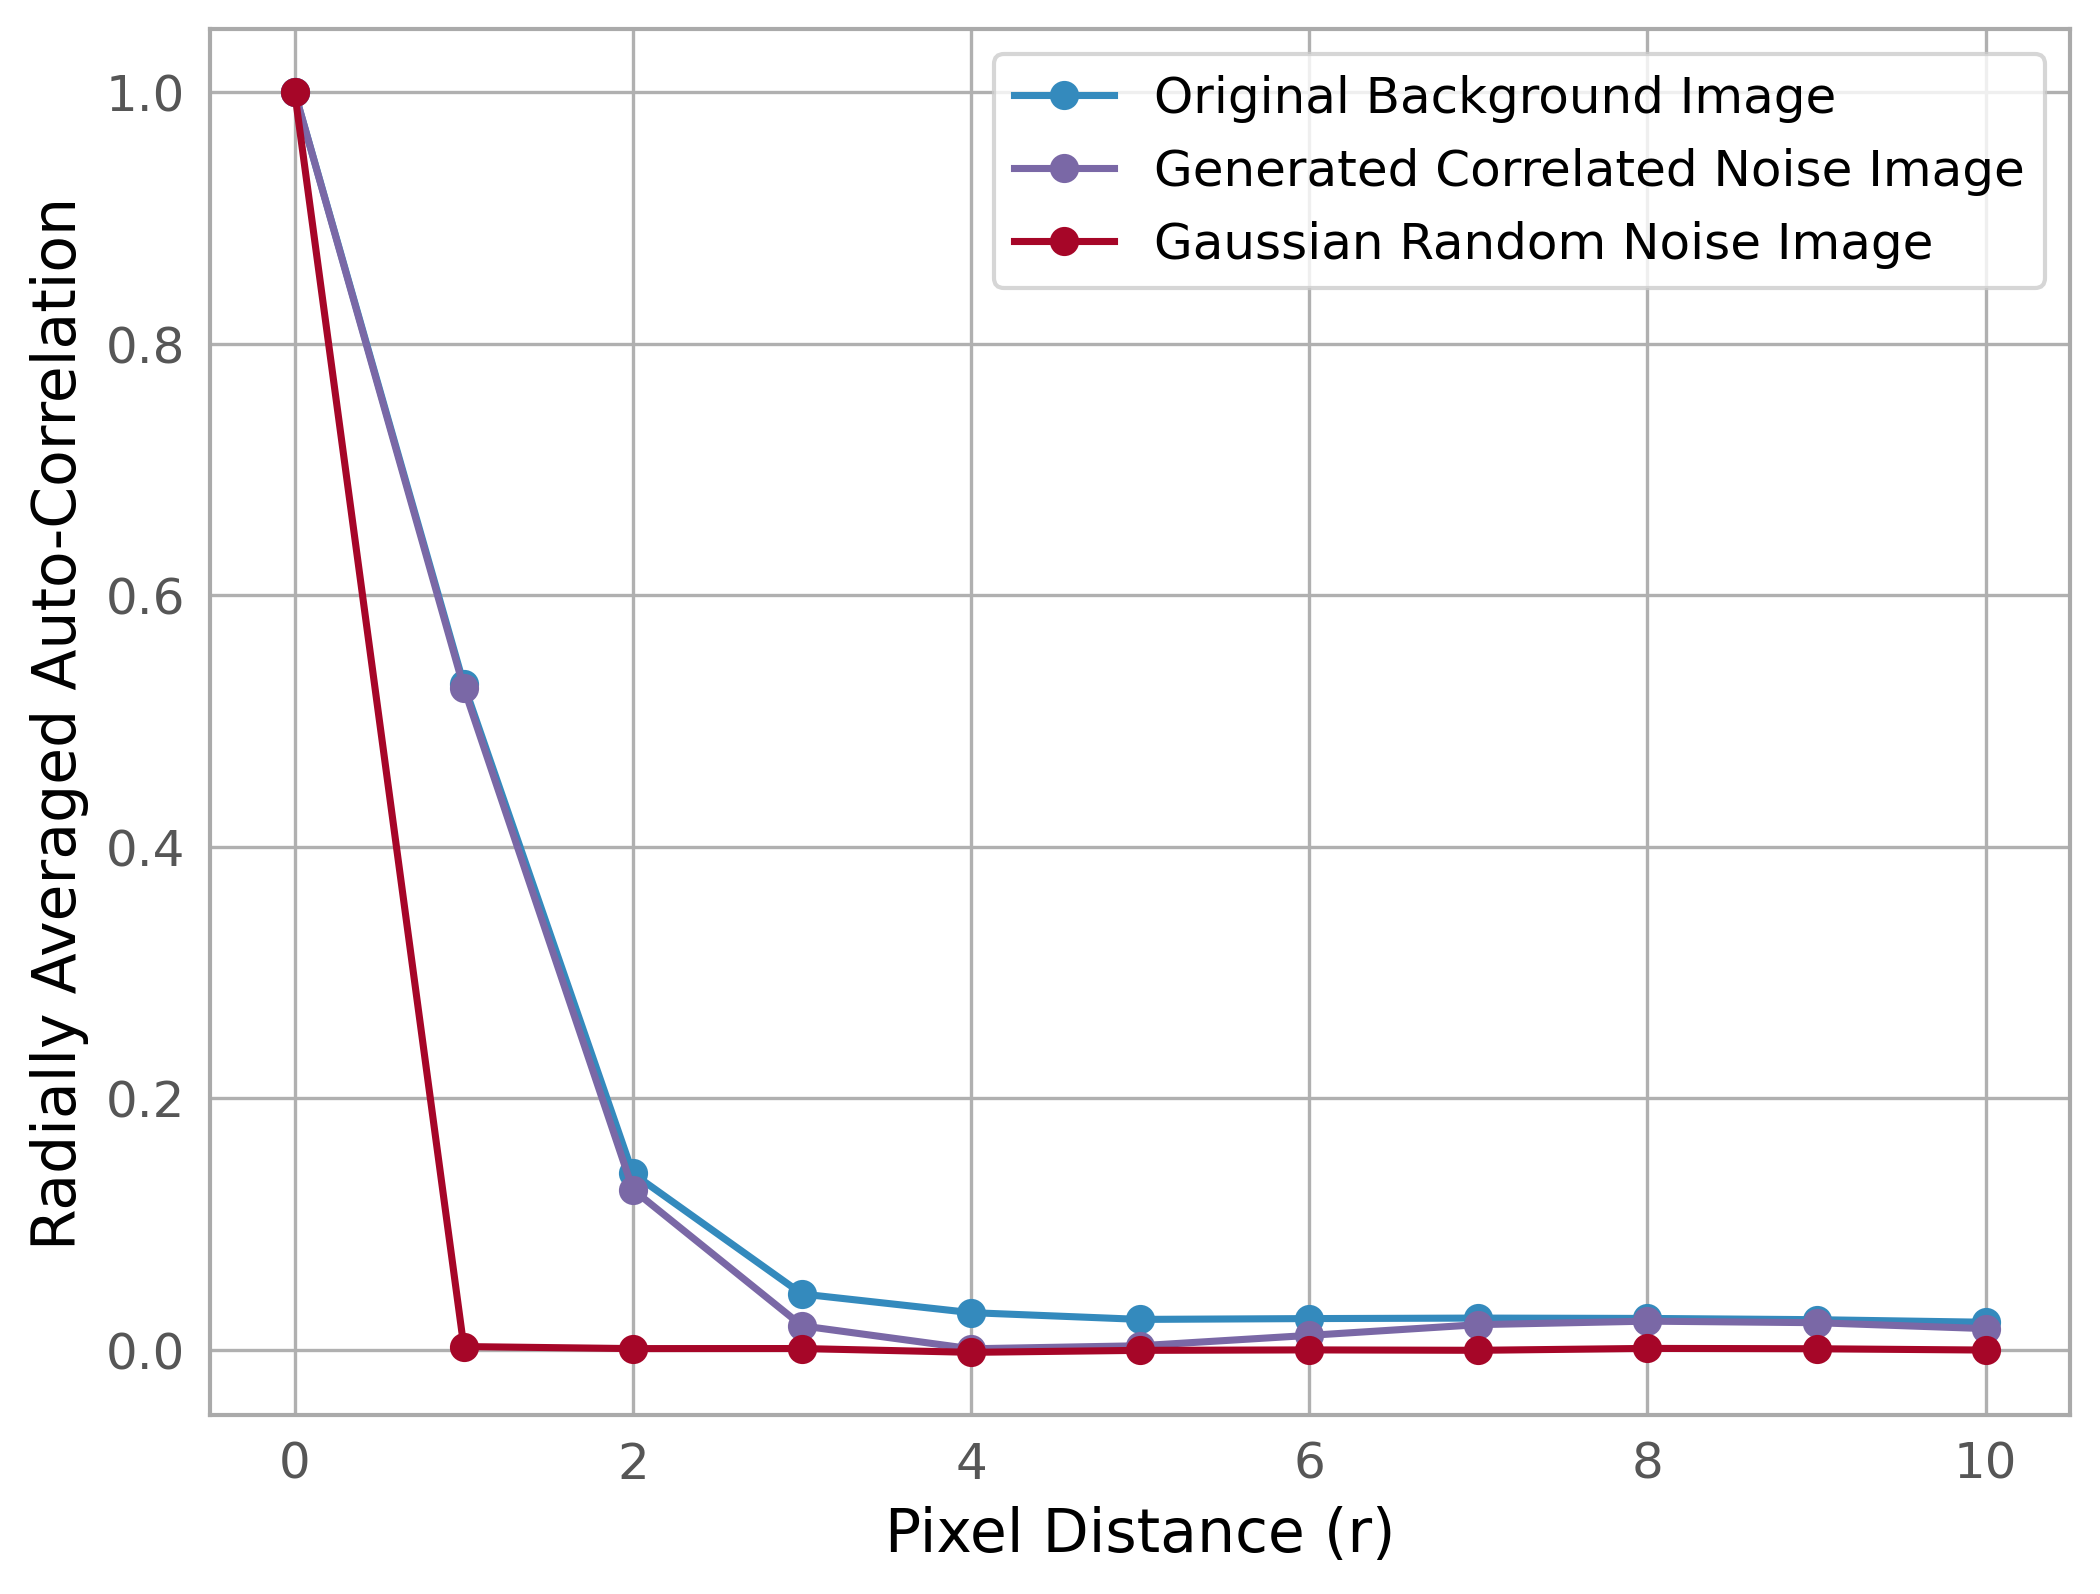

In [25]:
distances, correlations = calculate_radial_correlation(image_arr=cropped_data, subtract_mean=True, max_pixel_distance=10)

plt.plot(distances, correlations, marker='o', label='Original Background Image')

distances, correlations = calculate_radial_correlation(image_arr=arr, subtract_mean=True, max_pixel_distance=10)
plt.plot(distances, correlations, marker='o', label='Generated Correlated Noise Image')

# Generate a third image, same size, random noise
random_noise_image = np.random.normal(size=cropped_data.shape)
distances, correlations = calculate_radial_correlation(image_arr=random_noise_image, subtract_mean=True, max_pixel_distance=10)
plt.plot(distances, correlations, marker='o', label='Gaussian Random Noise Image')


plt.xlabel('Pixel Distance (r)')
plt.ylabel('Radially Averaged Auto-Correlation')

plt.legend()
